In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature', 'Humidity', 'Wind_Speed_kmh', 'Soil_Moisture', 
    'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos', 
    'Precipitation_accumulated'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TCNModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=36,
        output_chunk_length=24,
        num_filters=144,
        kernel_size=4,
        num_layers=2,
        dilation_base=1,
        weight_norm=False,
        batch_size=104,
        dropout=0.2,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 7, "min_lr": 1e-7},
        save_checkpoints=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.0019489201964000883, "weight_decay": 0.0008481827512796138},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 7.514
Metric val_loss improved by 0.517 >= min_delta = 0.001. New best score: 6.997
Metric val_loss improved by 0.101 >= min_delta = 0.001. New best score: 6.896
Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 6.854
Monitored metric val_loss did not improve in the last 10 records. Best score: 6.854. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE  ...       SMAPE        WMAPE
Temperature                1.515499e+05   389.294079  ...   73.331554  1245.960430
Humidity                   1.185362e+06  1088.743465  ...   90.090655   766.818451
Wind_Speed_kmh             8.310961e+02    28.828737  ...  124.699185  1696.880727
Soil_Moisture              1.913640e+06  1383.343882  ...   12.234948    12.381798
Soil_Temperature           1.902618e+05   436.190090  ...   74.011997  1404.686745
Wind_Dir_Sin               1.623066e+00     1.273996  ...  119.462209   196.421692
Wind_Dir_Cos               7.304447e+03    85.466059  ...  171.103087  6122.279326
Precipitation_accumulated  1.388530e+04   117.835903  ...   32.336491    46.718917

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE  ...       SMAPE        WMAPE
Temperature                1.518879e+05   389.727945  ...   73.451767  1249.840043
Humidity                   1.188006e+06  1089.956967  ...   90.273257   768.281700
Wind_Speed_kmh             8.329496e+02    28.860866  ...  124.898762  1700.139708
Soil_Moisture              1.917907e+06  1384.885071  ...   12.261546    12.411659
Soil_Temperature           1.906861e+05   436.676225  ...   74.135236  1409.483929
Wind_Dir_Sin               1.626486e+00     1.275338  ...  119.393522   196.403269
Wind_Dir_Cos               7.320740e+03    85.561321  ...  171.455171  6140.352885
Precipitation_accumulated  1.391627e+04   117.967245  ...   32.406624    46.720972

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE  ...       SMAPE        WMAPE
Temperature                1.523409e+05   390.308736  ...   73.637200  1253.662622
Humidity                   1.191550e+06  1091.581249  ...   90.512669   770.734005
Wind_Speed_kmh             8.354336e+02    28.903869  ...  125.004345  1701.549055
Soil_Moisture              1.923626e+06  1386.948343  ...   12.297412    12.452026
Soil_Temperature           1.912549e+05   437.326998  ...   74.327449  1413.733779
Wind_Dir_Sin               1.631079e+00     1.277137  ...  119.496932   196.651918
Wind_Dir_Cos               7.342576e+03    85.688833  ...  171.867666  6161.219726
Precipitation_accumulated  1.395778e+04   118.143053  ...   32.500879    46.723729

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE  ...       SMAPE        WMAPE
Temperature                1.527967e+05   390.892132  ...   73.790888  1256.389400
Humidity                   1.195114e+06  1093.212880  ...   90.769497   773.605069
Wind_Speed_kmh             8.379322e+02    28.947058  ...  125.044449  1702.586237
Soil_Moisture              1.929374e+06  1389.019119  ...   12.332625    12.491666
Soil_Temperature           1.918271e+05   437.980694  ...   74.516385  1416.888889
Wind_Dir_Sin               1.633949e+00     1.278260  ...  119.443597   196.506962
Wind_Dir_Cos               7.364540e+03    85.816901  ...  171.835611  6184.337369
Precipitation_accumulated  1.399954e+04   118.319650  ...   32.595302    46.726479

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE  ...       SMAPE        WMAPE
Temperature                1.532551e+05   391.478126  ...   73.893512  1258.855274
Humidity                   1.198701e+06  1094.851879  ...   91.038040   776.538693
Wind_Speed_kmh             8.404461e+02    28.990448  ...  125.148927  1703.887018
Soil_Moisture              1.935150e+06  1391.096783  ...   12.367410    12.530760
Soil_Temperature           1.924027e+05   438.637318  ...   74.670374  1419.756530
Wind_Dir_Sin               1.637140e+00     1.279508  ...  119.396940   196.465889
Wind_Dir_Cos               7.386635e+03    85.945537  ...  171.751097  6206.503696
Precipitation_accumulated  1.404155e+04   118.497041  ...   32.690341    46.729230

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE  ...       SMAPE        WMAPE
Temperature                1.537164e+05   392.066789  ...   74.044298  1261.622205
Humidity                   1.202308e+06  1096.498270  ...   91.308210   779.464323
Wind_Speed_kmh             8.429755e+02    29.034041  ...  125.211906  1704.449819
Soil_Moisture              1.940957e+06  1393.182333  ...   12.402488    12.570150
Soil_Temperature           1.929818e+05   439.296907  ...   74.837796  1422.919513
Wind_Dir_Sin               1.637035e+00     1.279467  ...  119.154342   196.573231
Wind_Dir_Cos               7.408867e+03    86.074775  ...  171.856567  6219.846693
Precipitation_accumulated  1.408381e+04   118.675232  ...   32.784567    46.731962

[8 rows x 6 columns]


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE  ...       SMAPE        WMAPE
Temperature                1.541804e+05   392.658137  ...   74.252161  1265.829426
Humidity                   1.205938e+06  1098.152094  ...   91.569739   781.990387
Wind_Speed_kmh             8.455201e+02    29.077828  ...  125.508958  1711.244794
Soil_Moisture              1.946811e+06  1395.281595  ...   12.438692    12.610646
Soil_Temperature           1.935643e+05   439.959471  ...   75.035950  1428.399188
Wind_Dir_Sin               1.641375e+00     1.281162  ...  118.910280   196.555747
Wind_Dir_Cos               7.431233e+03    86.204600  ...  172.287586  6244.344308
Precipitation_accumulated  1.412633e+04   118.854229  ...   32.877188    46.734653

[8 rows x 6 columns]
O MSE desse fold foi 440362.2775076426

Fold 2

Treinando o modelo...
Train set: 2773 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.139
Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.121
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.113
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.113. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU availa

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE         WMAPE
Temperature                    24.067903    4.905905  ...   34.397613  2.621592e+01
Humidity                       62.806245    7.925039  ...    7.539401  7.857770e+00
Wind_Speed_kmh                  0.250211    0.500211  ...  199.994936  1.444411e+07
Soil_Moisture              279285.804705  528.474980  ...    7.291062  7.609723e+00
Soil_Temperature               37.225121    6.101239  ...   50.127689  3.486220e+01
Wind_Dir_Sin                    0.211341    0.459718  ...  200.000000           inf
Wind_Dir_Cos                    0.966025    0.982866  ...  118.754315  8.143133e+01
Precipitation_accumulated    2337.744681   48.350229  ...    8.498018  9.017605e+00

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE         WMAPE
Temperature                    23.992346    4.898198  ...   34.376574  2.618689e+01
Humidity                       62.938598    7.933385  ...    7.552063  7.871620e+00
Wind_Speed_kmh                  0.250762    0.500761  ...  199.994925  1.443994e+07
Soil_Moisture              279695.788534  528.862731  ...    7.296611  7.615618e+00
Soil_Temperature               37.187368    6.098145  ...   50.143999  3.486117e+01
Wind_Dir_Sin                    0.211795    0.460212  ...  200.000000           inf
Wind_Dir_Cos                    0.968082    0.983912  ...  118.967184  8.156640e+01
Precipitation_accumulated    2342.954356   48.404074  ...    8.516343  9.037074e+00

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE         WMAPE
Temperature                    24.021051    4.901128  ...   34.423429  2.622511e+01
Humidity                       63.088303    7.942815  ...    7.563967  7.885163e+00
Wind_Speed_kmh                  0.251422    0.501420  ...  199.994910  1.442428e+07
Soil_Moisture              280327.899442  529.460007  ...    7.306243  7.625769e+00
Soil_Temperature               37.255440    6.103723  ...   50.236572  3.493148e+01
Wind_Dir_Sin                    0.212412    0.460882  ...  200.000000           inf
Wind_Dir_Cos                    0.970880    0.985332  ...  119.265463  8.175803e+01
Precipitation_accumulated    2349.926181   48.476037  ...    8.540195  9.062464e+00

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE         WMAPE
Temperature                    24.084412    4.907587  ...   34.502589  2.630300e+01
Humidity                       63.116324    7.944578  ...    7.561052  7.884218e+00
Wind_Speed_kmh                  0.252007    0.502003  ...  199.994894  1.440162e+07
Soil_Moisture              281003.706269  530.097827  ...    7.317152  7.637206e+00
Soil_Temperature               37.354469    6.111830  ...   50.356804  3.503418e+01
Wind_Dir_Sin                    0.213033    0.461555  ...  200.000000           inf
Wind_Dir_Cos                    0.973713    0.986769  ...  119.572298  8.195650e+01
Precipitation_accumulated    2356.950733   48.548437  ...    8.564876  9.088688e+00

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE         WMAPE
Temperature                    24.105710    4.909757  ...   34.544503  2.633562e+01
Humidity                       63.230922    7.951787  ...    7.567538  7.892691e+00
Wind_Speed_kmh                  0.252683    0.502676  ...  199.994879  1.438609e+07
Soil_Moisture              281636.330985  530.694197  ...    7.326701  7.647254e+00
Soil_Temperature               37.409073    6.116296  ...   50.439622  3.509385e+01
Wind_Dir_Sin                    0.213655    0.462228  ...  200.000000           inf
Wind_Dir_Cos                    0.976532    0.988196  ...  119.870077  8.214710e+01
Precipitation_accumulated    2364.018792   48.621176  ...    8.589786  9.115149e+00

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE         WMAPE
Temperature                    23.987214    4.897674  ...   34.512403  2.629219e+01
Humidity                       63.418449    7.963570  ...    7.587471  7.915392e+00
Wind_Speed_kmh                  0.253378    0.503366  ...  199.994864  1.437193e+07
Soil_Moisture              282108.449551  531.138823  ...    7.332261  7.653195e+00
Soil_Temperature               37.360542    6.112327  ...   50.465470  3.509610e+01
Wind_Dir_Sin                    0.214277    0.462900  ...  200.000000           inf
Wind_Dir_Cos                    0.979247    0.989569  ...  120.135930  8.231244e+01
Precipitation_accumulated    2371.131707   48.694268  ...    8.615167  9.142090e+00

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE         WMAPE
Temperature                    23.804288    4.878964  ...   34.447142  2.622077e+01
Humidity                       63.564173    7.972714  ...    7.598123  7.927472e+00
Wind_Speed_kmh                  0.254096    0.504080  ...  199.994848  1.436006e+07
Soil_Moisture              282469.089980  531.478212  ...    7.335557  7.656784e+00
Soil_Temperature               37.254573    6.103652  ...   50.463054  3.507300e+01
Wind_Dir_Sin                    0.214897    0.463570  ...  200.000000           inf
Wind_Dir_Cos                    0.981890    0.990903  ...  120.382682  8.246368e+01
Precipitation_accumulated    2378.289330   48.767708  ...    8.640963  9.169456e+00

[8 rows x 6 columns]
O MSE desse fold foi 35621.68165343636

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.044
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.033
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.030
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.025
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.025. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/py

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE      WMAPE
Temperature                    2.223666    1.491196  ...   14.943492  13.182713
Humidity                      12.990226    3.604196  ...    3.287306   3.312673
Wind_Speed_kmh                 0.197303    0.444188  ...  200.000000        inf
Soil_Moisture              73298.390331  270.736755  ...    4.033949   4.074930
Soil_Temperature               1.578079    1.256216  ...   11.893437  10.910476
Wind_Dir_Sin                   0.013504    0.116207  ...  200.000000        inf
Wind_Dir_Cos                   0.000438    0.020936  ...    1.502684   1.493516
Precipitation_accumulated      6.770451    2.602009  ...    0.497926   0.499442

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE      WMAPE
Temperature                    2.228584    1.492844  ...   14.974614  13.214608
Humidity                      13.018925    3.608175  ...    3.293774   3.319177
Wind_Speed_kmh                 0.197709    0.444645  ...  200.000000        inf
Soil_Moisture              73461.451892  271.037731  ...    4.042470   4.084213
Soil_Temperature               1.581182    1.257451  ...   11.911103  10.928077
Wind_Dir_Sin                   0.013534    0.116336  ...  200.000000        inf
Wind_Dir_Cos                   0.000439    0.020957  ...    1.504476   1.495292
Precipitation_accumulated      6.778680    2.603590  ...    0.498190   0.499707

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE      WMAPE
Temperature                    2.235159    1.495045  ...   15.015290  13.256015
Humidity                      13.057669    3.613540  ...    3.303033   3.328466
Wind_Speed_kmh                 0.198256    0.445259  ...  200.000000        inf
Soil_Moisture              73680.478136  271.441482  ...    4.054276   4.097070
Soil_Temperature               1.584985    1.258962  ...   11.931210  10.947751
Wind_Dir_Sin                   0.013574    0.116509  ...  200.000000        inf
Wind_Dir_Cos                   0.000440    0.020987  ...    1.507656   1.498448
Precipitation_accumulated      6.792593    2.606260  ...    0.498733   0.500254

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE      WMAPE
Temperature                    2.241703    1.497232  ...   15.054361  13.295331
Humidity                      13.096699    3.618936  ...    3.312576   3.338017
Wind_Speed_kmh                 0.198799    0.445869  ...  200.000000        inf
Soil_Moisture              73900.757101  271.846937  ...    4.066073   4.109921
Soil_Temperature               1.589075    1.260585  ...   11.953944  10.970116
Wind_Dir_Sin                   0.013614    0.116679  ...  200.000000        inf
Wind_Dir_Cos                   0.000442    0.021017  ...    1.511525   1.502289
Precipitation_accumulated      6.794417    2.606610  ...    0.498631   0.500152

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE      WMAPE
Temperature                    2.248404    1.499468  ...   15.097378  13.339313
Humidity                      13.135555    3.624301  ...    3.321327   3.346796
Wind_Speed_kmh                 0.199346    0.446482  ...  200.000000        inf
Soil_Moisture              74121.230391  272.252145  ...    4.077320   4.122187
Soil_Temperature               1.593772    1.262447  ...   11.986040  11.002671
Wind_Dir_Sin                   0.013654    0.116850  ...  200.000000        inf
Wind_Dir_Cos                   0.000443    0.021046  ...    1.514167   1.504897
Precipitation_accumulated      6.768493    2.601633  ...    0.497575   0.499090

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE      WMAPE
Temperature                    2.255054    1.501684  ...   15.138105  13.382149
Humidity                      13.164217    3.628253  ...    3.325571   3.351247
Wind_Speed_kmh                 0.199892    0.447093  ...  200.000000        inf
Soil_Moisture              74341.467624  272.656318  ...    4.088153   4.134023
Soil_Temperature               1.598480    1.264310  ...   12.018175  11.036200
Wind_Dir_Sin                   0.013694    0.117023  ...  200.000000        inf
Wind_Dir_Cos                   0.000444    0.021075  ...    1.516942   1.507638
Precipitation_accumulated      6.733099    2.594822  ...    0.496260   0.497766

[8 rows x 6 columns]


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE      WMAPE
Temperature                    2.261467    1.503817  ...   15.174046  13.418244
Humidity                      13.202900    3.633580  ...    3.333704   3.359536
Wind_Speed_kmh                 0.200435    0.447699  ...  200.000000        inf
Soil_Moisture              74562.386062  273.061140  ...    4.098900   4.145777
Soil_Temperature               1.603271    1.266203  ...   12.051881  11.071050
Wind_Dir_Sin                   0.013736    0.117199  ...  200.000000        inf
Wind_Dir_Cos                   0.000445    0.021106  ...    1.520964   1.511633
Precipitation_accumulated      6.720568    2.592406  ...    0.495608   0.497112

[8 rows x 6 columns]
O MSE desse fold foi 9323.298610546091

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.117
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.107
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.102
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.096
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.093
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.089
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.085
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.083
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.083. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE       WMAPE
Temperature                     4.488980    2.118721  ...   34.584170   31.114000
Humidity                       88.564150    9.410853  ...    9.942086   10.096779
Wind_Speed_kmh                  0.565241    0.751825  ...  153.165750  103.483062
Soil_Moisture              285166.611650  534.009936  ...    3.817149    4.182385
Soil_Temperature                6.093752    2.468553  ...   39.040798   35.296344
Wind_Dir_Sin                    0.270656    0.520247  ...  152.903716   95.339455
Wind_Dir_Cos                    0.389280    0.623923  ...   71.020510   49.097803
Precipitation_accumulated      12.358726    3.515498  ...    0.629429    0.627425

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE       WMAPE
Temperature                     4.497730    2.120785  ...   34.645175   31.200319
Humidity                       88.540163    9.409578  ...    9.939044   10.092668
Wind_Speed_kmh                  0.566495    0.752659  ...  153.061287  103.457831
Soil_Moisture              285802.414996  534.604915  ...    3.825250    4.190223
Soil_Temperature                6.106317    2.471096  ...   39.111748   35.397659
Wind_Dir_Sin                    0.271260    0.520826  ...  152.798668   95.335849
Wind_Dir_Cos                    0.390149    0.624619  ...   71.178847   49.238945
Precipitation_accumulated      12.385960    3.519369  ...    0.630646    0.628633

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE       WMAPE
Temperature                     4.506999    2.122969  ...   34.708622   31.270752
Humidity                       88.612436    9.413418  ...    9.941413   10.094178
Wind_Speed_kmh                  0.568179    0.753776  ...  152.921275  103.430435
Soil_Moisture              286654.804455  535.401536  ...    3.836372    4.200946
Soil_Temperature                6.123650    2.474601  ...   39.210743   35.538786
Wind_Dir_Sin                    0.272069    0.521603  ...  152.657874   95.334112
Wind_Dir_Cos                    0.391312    0.625550  ...   71.390979   49.428292
Precipitation_accumulated      12.422518    3.524559  ...    0.632292    0.630269

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE       WMAPE
Temperature                     4.518191    2.125604  ...   34.780403   31.351159
Humidity                       88.686474    9.417350  ...    9.943744   10.095633
Wind_Speed_kmh                  0.569878    0.754903  ...  152.780427  103.422361
Soil_Moisture              287512.077849  536.201527  ...    3.847306    4.211482
Soil_Temperature                6.141550    2.478215  ...   39.315707   35.688521
Wind_Dir_Sin                    0.272883    0.522382  ...  152.516237   95.334019
Wind_Dir_Cos                    0.392483    0.626485  ...   71.604263   49.618951
Precipitation_accumulated      12.459371    3.529783  ...    0.633973    0.631939

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE       WMAPE
Temperature                     4.530674    2.128538  ...   34.861939   31.445201
Humidity                       88.771042    9.421839  ...    9.946958   10.098054
Wind_Speed_kmh                  0.571588    0.756034  ...  152.638733  103.421384
Soil_Moisture              288374.384179  537.005013  ...    3.858215    4.221992
Soil_Temperature                6.159825    2.481900  ...   39.426083   35.847129
Wind_Dir_Sin                    0.273702    0.523165  ...  152.373750   95.332906
Wind_Dir_Cos                    0.393661    0.627424  ...   71.818335   49.810451
Precipitation_accumulated      12.496425    3.535028  ...    0.635658    0.633612

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE       WMAPE
Temperature                     4.543106    2.131456  ...   34.942538   31.536700
Humidity                       88.869687    9.427072  ...    9.951239   10.101640
Wind_Speed_kmh                  0.573308    0.757171  ...  152.496185  103.414794
Soil_Moisture              289242.148436  537.812373  ...    3.869424    4.232763
Soil_Temperature                6.178111    2.485581  ...   39.534959   36.002522
Wind_Dir_Sin                    0.274526    0.523952  ...  152.230405   95.329324
Wind_Dir_Cos                    0.394846    0.628367  ...   72.033477   50.003160
Precipitation_accumulated      12.533470    3.540264  ...    0.637286    0.635230

[8 rows x 6 columns]


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE  ...       SMAPE       WMAPE
Temperature                     4.551038    2.133316  ...   34.999787   31.592128
Humidity                       88.967955    9.432283  ...    9.955207   10.104880
Wind_Speed_kmh                  0.575031    0.758308  ...  152.352778  103.385202
Soil_Moisture              290115.039840  538.623282  ...    3.880588    4.243498
Soil_Temperature                6.194147    2.488804  ...   39.626711   36.127547
Wind_Dir_Sin                    0.275354    0.524742  ...  152.086195   95.322354
Wind_Dir_Cos                    0.396037    0.629315  ...   72.249939   50.197404
Precipitation_accumulated      12.570686    3.545516  ...    0.638912    0.636844

[8 rows x 6 columns]
O MSE desse fold foi 36278.57126111008

Fold 5

Treinando o modelo...
Train set: 6925 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.143
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.131
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.126
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.120
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.116
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.116. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE       WMAPE
Temperature                    9.078249    3.013013  ...   30.072945   24.509521
Humidity                      88.876960    9.427458  ...    8.809724    8.604259
Wind_Speed_kmh                 1.162621    1.078249  ...   69.741988   56.106179
Soil_Moisture              18763.615427  136.980347  ...    1.246009    1.233708
Soil_Temperature               4.358415    2.087682  ...   26.778948   20.052284
Wind_Dir_Sin                   0.619987    0.787392  ...  129.908997   93.509115
Wind_Dir_Cos                   0.445656    0.667575  ...  149.994669  102.106789
Precipitation_accumulated      3.764266    1.940172  ...    0.358186    0.357433

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE       WMAPE
Temperature                    9.098089    3.016304  ...   29.941119   24.502646
Humidity                      89.074195    9.437913  ...    8.828163    8.625175
Wind_Speed_kmh                 1.141985    1.068637  ...   69.605880   55.967615
Soil_Moisture              18789.224234  137.073791  ...    1.246567    1.234244
Soil_Temperature               4.365781    2.089445  ...   26.460524   20.031800
Wind_Dir_Sin                   0.620522    0.787732  ...  129.880444   93.532988
Wind_Dir_Cos                   0.445302    0.667310  ...  149.883133  102.070135
Precipitation_accumulated      3.772314    1.942244  ...    0.358822    0.358063

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE       WMAPE
Temperature                    9.122034    3.020270  ...   29.959257   24.511855
Humidity                      89.255195    9.447497  ...    8.839988    8.637191
Wind_Speed_kmh                 1.134376    1.065071  ...   69.624250   56.008671
Soil_Moisture              18834.589986  137.239171  ...    1.248213    1.235841
Soil_Temperature               4.377954    2.092356  ...   26.454663   20.032563
Wind_Dir_Sin                   0.621909    0.788612  ...  130.110158   93.736596
Wind_Dir_Cos                   0.446326    0.668077  ...  150.120567  102.138133
Precipitation_accumulated      3.780958    1.944469  ...    0.359289    0.358525

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE       WMAPE
Temperature                    9.131249    3.021796  ...   29.961144   24.508649
Humidity                      88.380061    9.401067  ...    8.796202    8.591835
Wind_Speed_kmh                 1.134058    1.064922  ...   69.713761   56.132288
Soil_Moisture              18871.031046  137.371871  ...    1.249085    1.236679
Soil_Temperature               4.390016    2.095236  ...   26.497649   20.046115
Wind_Dir_Sin                   0.623354    0.789528  ...  130.288207   93.886351
Wind_Dir_Cos                   0.446490    0.668199  ...  150.208366  102.190578
Precipitation_accumulated      3.788012    1.946282  ...    0.359596    0.358829

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE       WMAPE
Temperature                    9.157311    3.026105  ...   30.012355   24.527156
Humidity                      87.843678    9.372496  ...    8.764983    8.558863
Wind_Speed_kmh                 1.136943    1.066275  ...   69.841180   56.235958
Soil_Moisture              18900.025868  137.477365  ...    1.249539    1.237112
Soil_Temperature               4.400212    2.097668  ...   26.489929   20.039226
Wind_Dir_Sin                   0.624082    0.789989  ...  130.317892   93.934836
Wind_Dir_Cos                   0.446448    0.668168  ...  150.119630  102.148716
Precipitation_accumulated      3.790447    1.946907  ...    0.359560    0.358793

[8 rows x 6 columns]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE       WMAPE
Temperature                    9.179060    3.029696  ...   29.913919   24.498345
Humidity                      87.792231    9.369751  ...    8.757550    8.548825
Wind_Speed_kmh                 1.135621    1.065655  ...   69.663153   56.127164
Soil_Moisture              18911.990226  137.520872  ...    1.249001    1.236571
Soil_Temperature               4.412692    2.100641  ...   26.497102   20.037980
Wind_Dir_Sin                   0.625467    0.790865  ...  130.528124   94.044768
Wind_Dir_Cos                   0.445711    0.667616  ...  149.973938  102.068083
Precipitation_accumulated      3.797658    1.948758  ...    0.359903    0.359132

[8 rows x 6 columns]
Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE  ...       SMAPE 

In [5]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"model_{best_fold}/", best=True)

TCNModel(output_chunk_shift=0, kernel_size=4, num_filters=144, num_layers=2, dilation_base=1, weight_norm=False, dropout=0.2, model_name=model_5, input_chunk_length=36, output_chunk_length=24, batch_size=104, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x773431d89550>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 7, 'min_lr': 1e-07}, save_checkpoints=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.0019489201964000883, 'weight_decay': 0.0008481827512796138})

In [6]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Humidity', 'Wind_Speed_kmh',
       'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos',
       'Precipitation_accumulated', 'fold'],
      dtype='object', name='component')


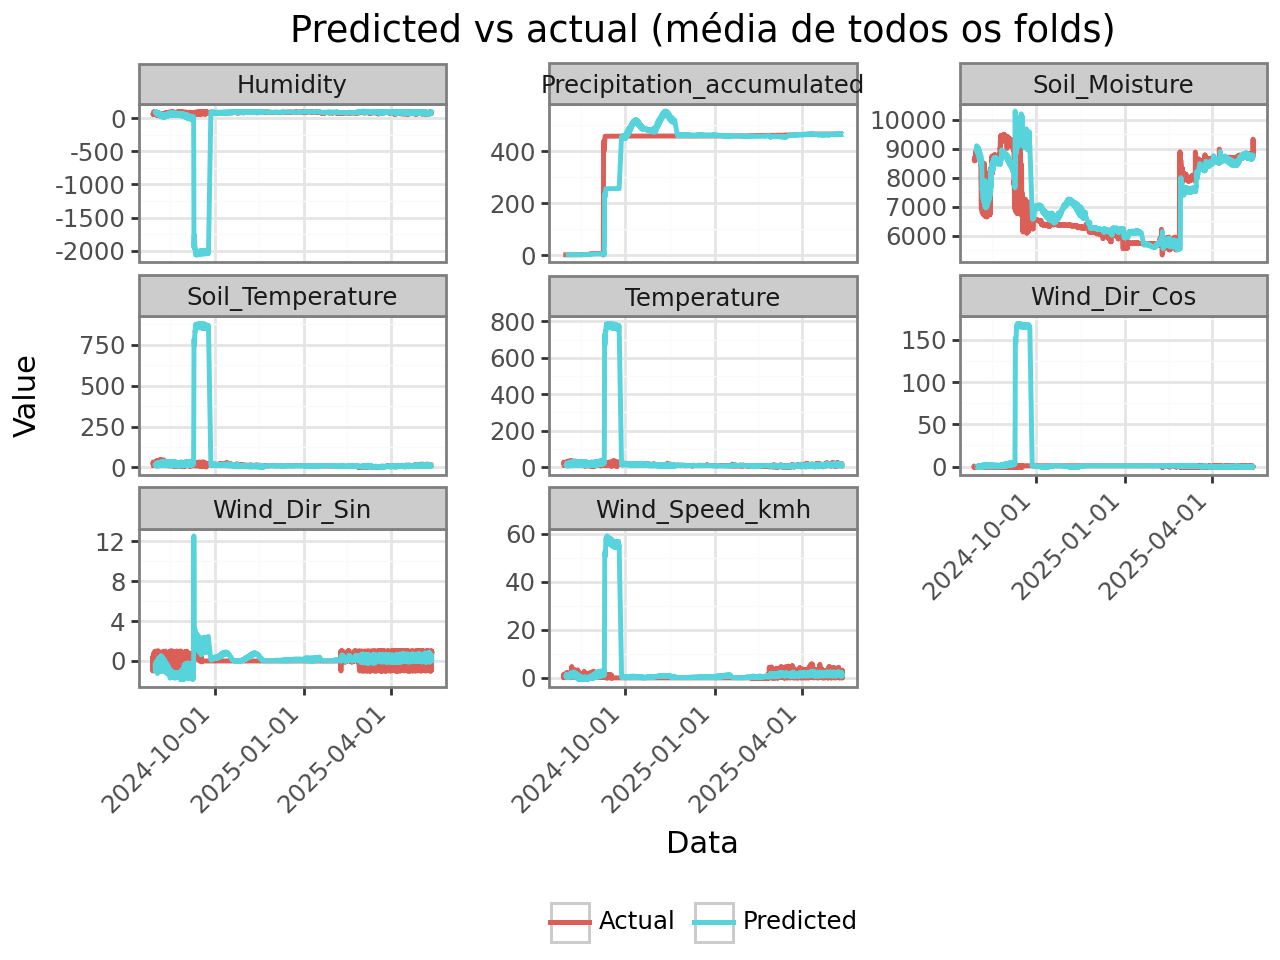

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


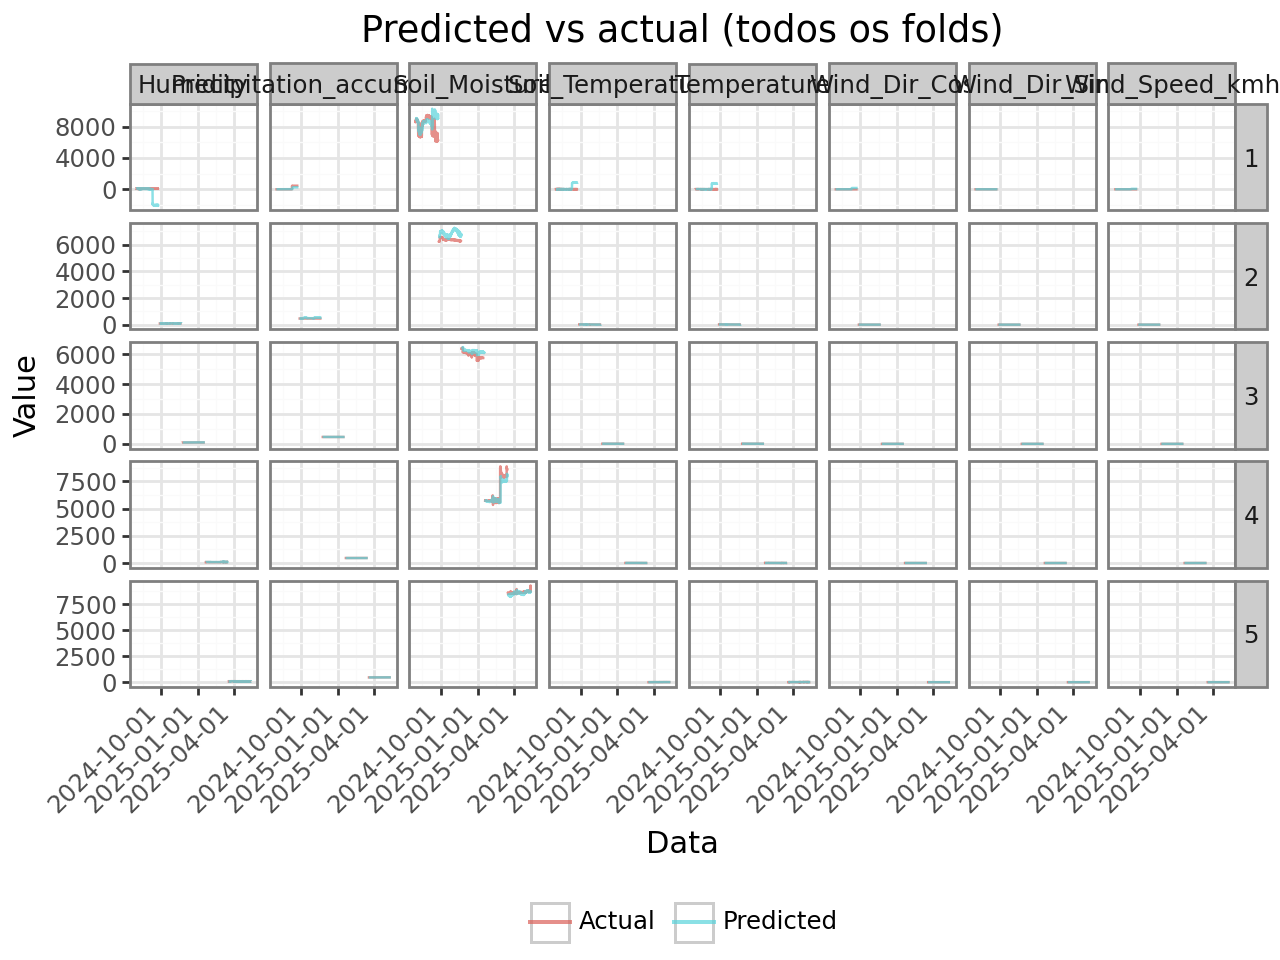

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_220191/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


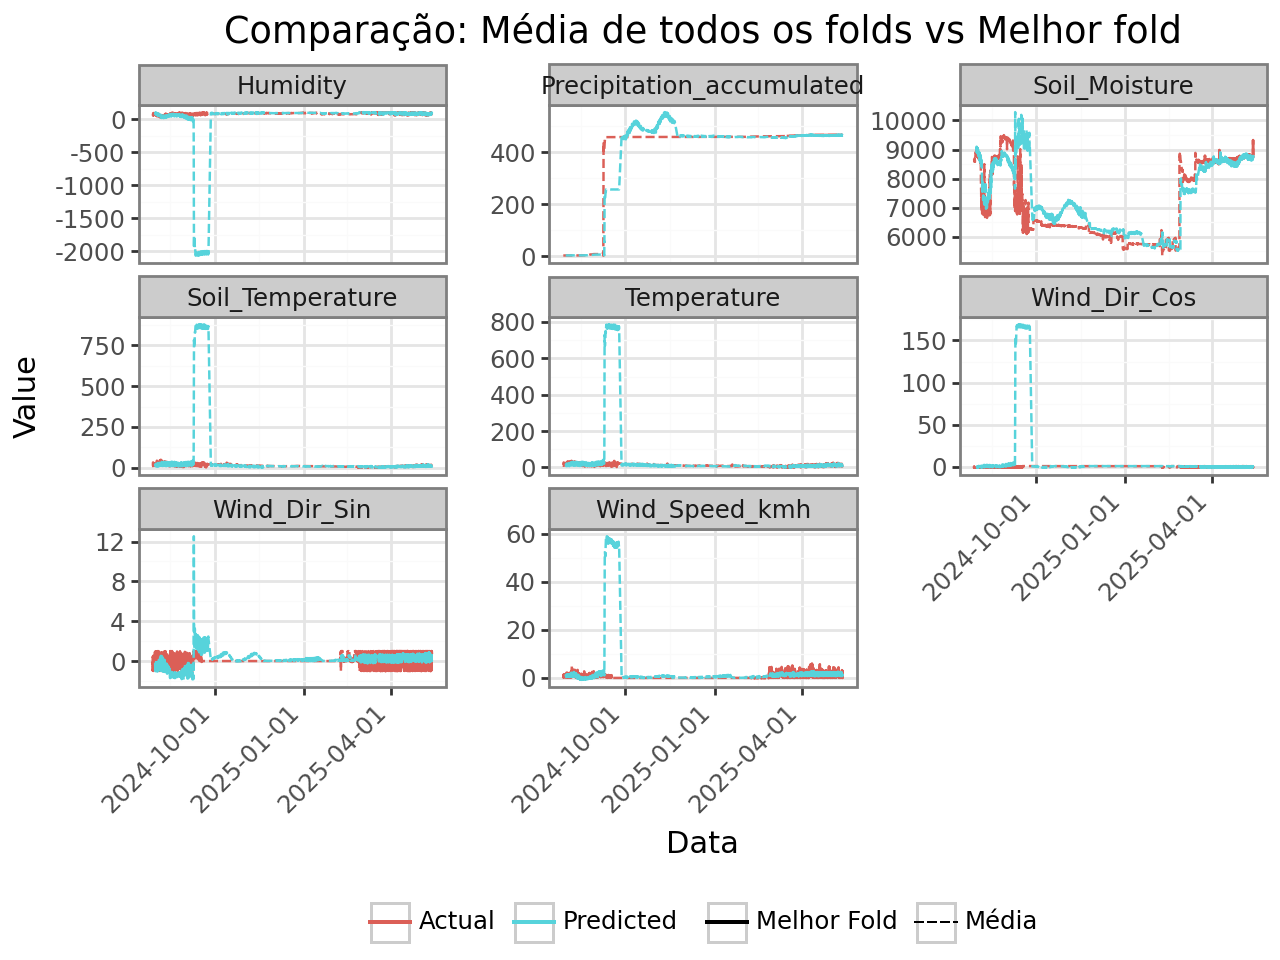

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [7]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [8]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
